In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import torch
from ggs.data.utils.tokenize import Encoder
from ggs.models.predictors import BaseCNN
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [2]:
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# RUN CELL ONLY ONCE PER KERNEL
np.random.seed(42)
n = 7
noise_scale = 0.4
alphabet = 'ABCDEFG'
noisy_reward_vec = np.eye(n) + (1 - np.eye(n))*np.random.normal(scale=noise_scale, size=(n,n))
def true_noep_reward(x):
    return np.sum(x*np.eye(n), axis=(-1,-2))

def noisy_noep_reward(x):
    return np.sum(x * noisy_reward_vec, axis=(-1, -2))

def seq_to_oh(seq):
    return np.array([np.array([1 if char == letter else 0 for char in alphabet]) for letter in seq])


# Setup Graph and Predictors

In [9]:
ROOT_DIR = '/om2/user/kirjner/protein_design'

diag_seed1_df = pd.read_csv(ROOT_DIR + '/GGS-private/ckpt/Diagonal/mutations_0/percentile_0.0_1.0/smoothed/no_epistasis_constrained/samples/run_2023-08-07_21-06/seed_1.csv')
diag_G = nx.DiGraph()
parents = diag_seed1_df.source_sequences
children = diag_seed1_df.mutant_sequences

# Add edges to the digraph G

for i in range(len(parents)):
    diag_G.add_edge(parents[i], children[i])

roots = [n for n, d in diag_G.in_degree() if d == 0]
leaves = [n for n, d in diag_G.out_degree() if d == 0]

smoothed_diag_predictor = torch.load(ROOT_DIR + '/GGS-private/ckpt/Diagonal/mutations_0/percentile_0.0_1.0/smoothed/no_epistasis_constrained/last.ckpt')
predictor_dict = smoothed_diag_predictor['state_dict']
predictor_dict = {k.replace('predictor.', ''): v for k, v in predictor_dict.items()}
smoothed_mdl = BaseCNN(n_tokens = 7, seq_len = 7, input_size = 32)
smoothed_mdl.load_state_dict(predictor_dict)
smoothed_mdl.eval().to(device)

unsmoothed_diag_predictor = torch.load(ROOT_DIR + '/GGS-private/ckpt/Diagonal/mutations_0/percentile_0.0_1.0/unsmoothed/no_epistasis_constrained/last.ckpt')
uns_predictor_dict = unsmoothed_diag_predictor['state_dict']
uns_predictor_dict = {k.replace('predictor.', ''): v for k, v in uns_predictor_dict.items()}
unsmoothed_mdl = BaseCNN(n_tokens = 7, seq_len = 7, input_size = 32)
unsmoothed_mdl.load_state_dict(uns_predictor_dict)
unsmoothed_mdl.eval().to(device)

diag_encoder = Encoder('ABCDEFG')


# Score Leaf Nodes and Produce Paths for best Leaves

In [15]:
leave_scores = [noisy_noep_reward(seq_to_oh(leaf)) for leaf in leaves]
best_leaves = np.array(leaves)[np.argpartition(leave_scores, -500)[-500:]]

In [16]:
paths = []
for root in tqdm(roots, total = len(roots)):
    for leaf in best_leaves:
        paths.extend(nx.all_simple_paths(diag_G, root, leaf, cutoff=5))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 393/393 [00:46<00:00,  8.50it/s]


In [8]:
maxlen = lambda seq: max([len(s) for s in seq])
maxlen_idx = lambda seq: np.argmax([len(s) for s in seq])

# Evaluate Paths

In [29]:
path_fitness_scores = []
path_smoothed_pred_scores = []
path_unsmoothed_pred_scores = []
# To store the best path
best_path = None
max_dips = -1  # Counter for the largest number of dips found

for path in tqdm(paths):
    if len(path) < 3:
        continue

    oh_path = [seq_to_oh(seq) for seq in path]
    encoded_path = diag_encoder.encode(path).to(device)
    smoothed_pred_scores = smoothed_mdl(encoded_path).detach().cpu().numpy()
    unsmoothed_pred_scores = unsmoothed_mdl(encoded_path).detach().cpu().numpy()
    fitness_scores = [noisy_noep_reward(l) for l in oh_path]
    fitness_dips_indices = np.where(np.diff(fitness_scores) < 0)[0]
    
    # Checking if unsmoothed model score is decreasing at the indices where true score dips
    if len(fitness_dips_indices) > 0 and any(np.diff(unsmoothed_pred_scores)[index] < 0 for index in fitness_dips_indices):
        # Using np.diff and np.sign to check if predicted scores are non-decreasing
        if all(sign >= 0 for sign in np.diff(smoothed_pred_scores)):
            dips = len(fitness_dips_indices)
            if dips > max_dips:
                max_dips = dips
                best_path = path
                path_fitness_scores.append(fitness_scores)
                path_smoothed_pred_scores.append(smoothed_pred_scores)
                path_unsmoothed_pred_scores.append(unsmoothed_pred_scores)
            



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4318/4318 [00:06<00:00, 705.10it/s]


# Plot Example Path

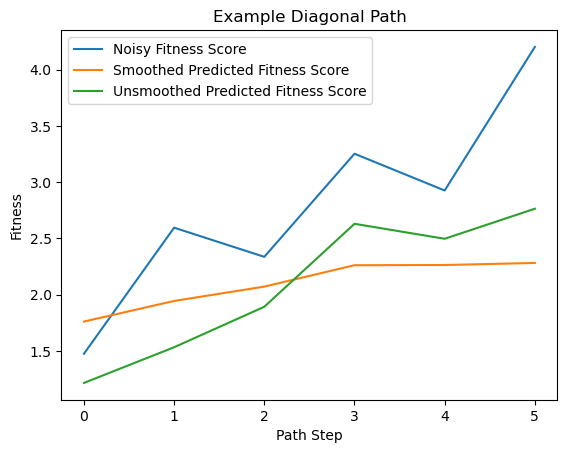

In [31]:
plt.plot(path_fitness_scores[maxlen_idx(path_fitness_scores)], label = 'Noisy Fitness Score')
plt.plot(path_smoothed_pred_scores[maxlen_idx(path_smoothed_pred_scores)], label = 'Smoothed Predicted Fitness Score')
plt.plot(path_unsmoothed_pred_scores[maxlen_idx(path_unsmoothed_pred_scores)], label = 'Unsmoothed Predicted Fitness Score')
plt.xlabel("Path Step")
plt.ylabel("Fitness")
plt.title("Example Diagonal Path")
plt.legend()